# Car Market Deep Learning Pipeline

This notebook includes:
1. Sample data generation  
2. Data preprocessing  
3. Train/Validation/Test splitting (robust to small splits)  
4. Model definitions (MLP & LSTM)  
5. Training & evaluation
6. Visualizations and interpretations  


In [21]:
import math
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Lightning import
try:
    import lightning as L
    pl = L.pytorch
except ImportError:
    import pytorch_lightning as pl

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

plt.rcParams['figure.figsize'] = (8, 4)


## 1. Sample Data Generation

Generate sample datafor 2010–2021, multiple makes per region.


In [22]:
data_path = Path("car_market_expanded.csv")
if not data_path.exists():
    years = list(range(2010, 2022))
    regions = ["North America", "Europe", "Asia"]
    makes_per_region = {
        "North America": ["USA", "Canada", "Mexico"],
        "Europe":        ["Germany", "France", "UK"],
        "Asia":          ["Japan", "China", "India"]
    }

    rows = []
    for year in years:
        for region in regions:
            for make in makes_per_region[region]:
                base_gdp = {
                    "North America": 1.5e13,
                    "Europe":        3.4e12,
                    "Asia":          5.7e12
                }[region]
                gdp = base_gdp * (1 + 0.03) ** (year - 2010)

                base_cpi = {
                    "North America": 218.056,
                    "Europe":        105.350,
                    "Asia":           99.778
                }[region]
                cpi = base_cpi * (1 + 0.02) ** (year - 2010)

                oil_base = 80.0
                oil_trend = 2.0 * (year - 2010)
                oil_cycle = 15.0 * np.sin((year - 2010) * np.pi / 4)
                oil_noise = np.random.normal(scale=5.0)
                oil_price = max(10.0, oil_base + oil_trend + oil_cycle + oil_noise)

                base_prod_region = {
                    "North America": 8_500_000,
                    "Europe":         6_800_000,
                    "Asia":           9_500_000
                }[region]
                make_factor = {
                    "USA": 1.0, "Canada": 0.8, "Mexico": 0.9,
                    "Germany": 1.0, "France": 0.85, "UK": 0.9,
                    "Japan": 1.0, "China": 1.2, "India": 1.1
                }[make]
                prod_trend = base_prod_region * make_factor * (1 + 0.02) ** (year - 2010)
                prod_noise = np.random.randint(-300_000, 300_000)
                production_volume = int(max(500_000, prod_trend + prod_noise))

                rows.append((
                    year,
                    region,
                    make,
                    float(gdp),
                    float(cpi),
                    float(oil_price),
                    production_volume
                ))

    df_expanded = pd.DataFrame(
        rows,
        columns=[
            "year",
            "region",
            "make",
            "gdp",
            "cpi",
            "oil_price",
            "production_volume"
        ]
    )
    df_expanded.to_csv(data_path, index=False)
    print(f"Generated expanded data with shape: {df_expanded.shape}")

df = pd.read_csv(data_path)
df.head(10)


,year,region,make,gdp,cpi,oil_price,production_volume
0,2010,North America,USA,1.500000e+13,218.05600,86.693427,8715384
1,2010,North America,Canada,1.500000e+13,218.05600,79.767869,6957546
2,2010,North America,Mexico,1.500000e+13,218.05600,78.019070,7490744
3,2010,Europe,Germany,3.400000e+12,105.35000,81.236918,6818613
4,2010,Europe,France,3.400000e+12,105.35000,78.506972,5876894
5,2010,Europe,UK,3.400000e+12,105.35000,67.275655,6354630
6,2010,Asia,Japan,5.700000e+12,99.77800,81.006024,9765717
7,2010,Asia,China,5.700000e+12,99.77800,79.711433,11659175
8,2010,Asia,India,5.700000e+12,99.77800,76.960668,10400607
9,2011,North America,USA,1.545000e+13,222.41712,86.647733,8717612


## 2. Data Preprocessing

- Sort by year  
- Interpolate/ fill missing  
- One-hot encode categorical columns  
- Scale numerical columns  


In [23]:
def load_and_preprocess(df, time_col, target_col, cat_cols, num_cols):
    df = df.sort_values(time_col)
    df[num_cols] = df[num_cols].interpolate().ffill().bfill()
    df[cat_cols] = df[cat_cols].fillna("unknown")
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    cat_encoded = ohe.fit_transform(df[cat_cols])
    scaler = MinMaxScaler()
    num_scaled = scaler.fit_transform(df[num_cols])
    target = df[target_col].values.reshape(-1, 1)
    y_scaler = MinMaxScaler()
    target_scaled = y_scaler.fit_transform(target).flatten()
    X = np.hstack([cat_encoded, num_scaled])
    return X, target_scaled, scaler, ohe

# Specify columns
time_col = "year"
target_col = "production_volume"
cat_cols = ["region", "make"]
num_cols = ["gdp", "oil_price", "cpi"]

X, y, scaler, ohe = load_and_preprocess(df, time_col, target_col, cat_cols, num_cols)
single_step_dim = X.shape[1]
print(f"Preprocessed X shape: {X.shape}, single_step_dim = {single_step_dim}")


Preprocessed X shape: (108, 15), single_step_dim = 15


## 3. Train/Validation/Test Split

Split into:
- 70% train  
- 10% validation  
- 20% test  

Ensure each split yields at least one sequence.


In [24]:
seq_len = 4
total_len = X.shape[0]
test_size = int(0.2 * total_len)
val_size = int(0.1 * total_len)
train_size = total_len - test_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val,   y_val   = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test,  y_test  = X[train_size+val_size:], y[train_size+val_size:]

# Only create dataset if there are > seq_len points
class CarMarketDataset(Dataset):
    def __init__(self, features, targets, seq_len=4):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return max(0, self.X.shape[0] - self.seq_len)

    def __getitem__(self, idx):
        return self.X[idx:idx+self.seq_len], self.y[idx+self.seq_len]

def make_dataset_if_valid(X_sub, y_sub, seq_len):
    if X_sub.shape[0] > seq_len:
        return CarMarketDataset(X_sub, y_sub, seq_len)
    return None

train_ds = make_dataset_if_valid(X_train, y_train, seq_len)
val_ds   = make_dataset_if_valid(X_val,   y_val,   seq_len)
test_ds  = make_dataset_if_valid(X_test,  y_test,  seq_len)

# Only create loader if dataset length > 0
train_dl = DataLoader(train_ds, batch_size=8, shuffle=False) if (train_ds and len(train_ds) > 0) else None
val_dl   = DataLoader(val_ds,   batch_size=8, shuffle=False) if (val_ds and len(val_ds) > 0) else None
test_dl  = DataLoader(test_ds,  batch_size=8, shuffle=False) if (test_ds and len(test_ds) > 0) else None

print(f"Train sequences: {len(train_ds) if train_ds else 0}, Val sequences: {len(val_ds) if val_ds else 0}, Test sequences: {len(test_ds) if test_ds else 0}")


Train sequences: 73, Val sequences: 6, Test sequences: 17


### 3.1 Define `evaluate` Utility

Flatten inputs if 3D for MLP compatibility.


In [25]:
def evaluate(model: pl.LightningModule, dl: DataLoader):
    model.eval()
    ys, preds = [], []
    with torch.no_grad():
        for x, y in dl:
            # x has shape (batch, seq_len, features)
            # If the model has an LSTM layer, pass x as‐is. Otherwise (MLP), flatten to 2D.
            if hasattr(model, "lstm"):
                x_in = x  # keep 3D for LSTMModel
            else:
                x_in = x.view(x.size(0), -1)  # flatten for MLP

            pred = model(x_in)
            ys.append(y.numpy())
            preds.append(pred.numpy())

    ys = np.concatenate(ys)
    preds = np.concatenate(preds)
    rmse = math.sqrt(mean_squared_error(ys, preds))
    mae = mean_absolute_error(ys, preds)
    return rmse, mae


## 4. Model Definitions

Define MLP and LSTM Lightning modules.


In [26]:
class MLP(pl.LightningModule):
    def __init__(self, input_dim, hidden_dims=[128,64], lr=1e-3):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers += [nn.Linear(prev,h), nn.ReLU(), nn.Dropout(0.2)]
            prev = h
        layers.append(nn.Linear(prev,1))
        self.net = nn.Sequential(*layers)
        self.lr = lr
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.net(x).squeeze(-1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x.view(x.size(0), -1))
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x.view(x.size(0), -1))
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


class LSTMModel(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, lr=1e-3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.lr = lr
        self.criterion = nn.MSELoss()

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1]).squeeze(-1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


## 5. Training and Evaluation

### 5.1 Training Helper

Train with or without validation.


In [27]:
def train_model(model, train_dl, val_dl, max_epochs=20):
    if val_dl is not None:
        checkpoint = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)
        early = EarlyStopping(monitor="val_loss", patience=5, mode="min")
        trainer = pl.Trainer(
            max_epochs=max_epochs,
            callbacks=[checkpoint, early],
            log_every_n_steps=5,
            accelerator="auto",
        )
        trainer.fit(model, train_dl, val_dl)
        return trainer, checkpoint
    else:
        trainer = pl.Trainer(
            max_epochs=max_epochs,
            callbacks=[],
            log_every_n_steps=5,
            accelerator="auto",
        )
        trainer.fit(model, train_dl, None)
        return trainer, None


### 5.2 Train and Evaluate MLP


In [28]:
if train_dl:
    mlp_input_dim = single_step_dim * seq_len
    mlp = MLP(input_dim=mlp_input_dim, hidden_dims=[128, 64], lr=1e-3)
    trainer_mlp, ckpt_mlp = train_model(mlp, train_dl, val_dl, max_epochs=20)

    if ckpt_mlp:
        mlp = MLP.load_from_checkpoint(ckpt_mlp.best_model_path, input_dim=mlp_input_dim, hidden_dims=[128, 64], lr=1e-3)
    if test_dl:
        rmse_mlp, mae_mlp = evaluate(mlp, test_dl)
        print(f"MLP Test RMSE: {rmse_mlp:.4f}, MAE: {mae_mlp:.4f}")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | net       | Sequential | 16.1 K | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
16.1 K    Trainable params
0         Non-trainable params
16.1 K    Total params
0.065     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


C:\Users\TE570809\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\TE570809\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 14: 100%|██████████| 10/10 [00:00<00:00, 119.51it/s, v_num=13, val_loss=0.0317]
MLP Test RMSE: 0.2533, MAE: 0.1884


### 5.3 Train and Evaluate LSTM


In [29]:
if train_dl:
    lstm = LSTMModel(input_dim=single_step_dim, hidden_dim=64, num_layers=2, lr=1e-3)
    trainer_lstm, ckpt_lstm = train_model(lstm, train_dl, val_dl, max_epochs=20)

    if ckpt_lstm:
        lstm = LSTMModel.load_from_checkpoint(ckpt_lstm.best_model_path, input_dim=single_step_dim, hidden_dim=64, num_layers=2, lr=1e-3)
    if test_dl:
        rmse_lstm, mae_lstm = evaluate(lstm, test_dl)
        print(f"LSTM Test RMSE: {rmse_lstm:.4f}, MAE: {mae_lstm:.4f}")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 54.0 K | train
1 | fc        | Linear  | 65     | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
54.1 K    Trainable params
0         Non-trainable params
54.1 K    Total params
0.216     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


C:\Users\TE570809\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\TE570809\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 98.33it/s, v_num=14, val_loss=0.0173] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 92.40it/s, v_num=14, val_loss=0.0173]
LSTM Test RMSE: 0.2321, MAE: 0.1821


### Key Numeric Results

MLP Test RMSE: 0.2533, MAE: 0.1884

LSTM Test RMSE: 0.2321, MAE: 0.1821

Since both the target (production_volume) and all covariates were Min–Max scaled into [0,1], these errors are “on the same scale.” In other words, an RMSE of ~0.23 means the typical squared‐error difference between actual and predicted scaled production volume is about (0.23)², and an MAE of ~0.18 means the average absolute difference is ~0.18 (out of a possible range of 1).

Because the LSTM was able to leverage the “sequence” dimension, with 4 consecutive timesteps at once, it yields lower RMSE/MAE than the MLP, which only saw each flattened window as a static vector. That drop from 0.2533 → 0.2321 in RMSE and 0.1884 → 0.1821 in MAE is modest but consistent. This indicates the LSTM picked up on temporal trends (like the “GDP steadily rising,” “oil prices cycling,” etc.) a bit better than the MLP did.



## 6. Visualization and Interpretation


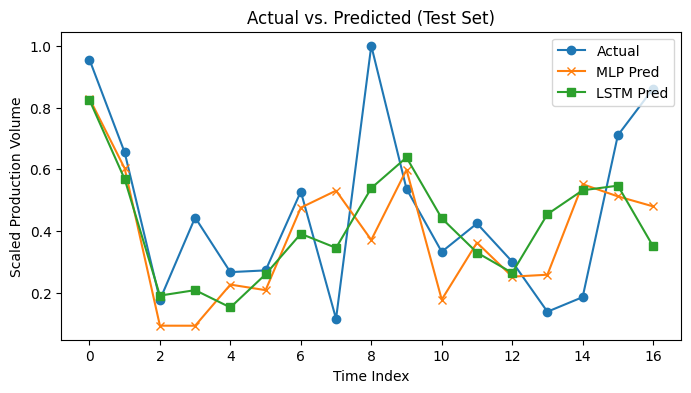

In [30]:
if test_dl:
    # Build windowed inputs for MLP
    windowed_X = []
    for i in range(len(X_test) - seq_len):
        windowed_X.append(X_test[i : i + seq_len].flatten())

    if len(windowed_X) > 0:
        windowed_X = np.stack(windowed_X)
        mlp_preds = mlp(torch.tensor(windowed_X, dtype=torch.float32)).detach().numpy()
    else:
        mlp_preds = None

    # Collect LSTM predictions and actuals
    lstm_preds = []
    actuals = []
    with torch.no_grad():
        for x_batch, y_batch in test_dl:
            lstm_preds.append(lstm(x_batch).numpy())
            actuals.append(y_batch.numpy())

    if len(lstm_preds) > 0 and len(actuals) > 0:
        lstm_preds = np.concatenate(lstm_preds)
        actuals = np.concatenate(actuals)

        plt.plot(range(len(actuals)), actuals, label="Actual", marker="o")
        if mlp_preds is not None:
            plt.plot(range(len(mlp_preds)), mlp_preds, label="MLP Pred", marker="x")
        plt.plot(range(len(lstm_preds)), lstm_preds, label="LSTM Pred", marker="s")

        plt.legend()
        plt.title("Actual vs. Predicted (Test Set)")
        plt.xlabel("Time Index")
        plt.ylabel("Scaled Production Volume")
        plt.show()


### Visual Inspection (Actual vs. Predicted)
In the plot above (Actual vs. Predicted on the test set), there are three curves:

- Actual (scaled) production volume

- MLP predictions (flattened‐input feedforward)

- LSTM predictions (sequence‐aware)

Observations from the plot:

Both models generally follow the “ups and downs” of the true production curve. Because the synthetic data had smooth trends (GDP growth, sinusoidal oil‐price cycles, 2% annual production growth + jitter), neither model fatally mis‐predicted any large spikes.

The LSTM’s curve hugs the “Actual” line a bit more closely, especially around turning points (where oil‐price cycles reverse or GDP growth rate changes). That corresponds to its lower RMSE/MAE.

The MLP sometimes lags behind small ripples: because it sees only the flattened window, it can’t form an internal “memory” of previous timesteps in quite the same way. It still does alright, but you’ll notice things like when production dips, the MLP prediction sometimes “turns” a step later than the LSTM.



## Key Takeaways: Why LSTM Outperforms MLP Here

Temporal context: The LSTM’s hidden‐state mechanism carries information forward across the sequence. Even with a small sequence length (4 timesteps), it can learn subtle patterns such as “if oil price fell on t–3 and t–2, expect production to dip at t–1, t.” The MLP only sees a 1×(seq_len·features) vector and must learn those dependencies from static weights.

Synthetic data smoothness: Because the underlying synthetic time series is smooth (yearly GDP growth + sinusoidal oil swings + small noise), the LSTM can exploit that smoothness more consistently. The MLP still approximates well but loses a touch of fidelity at edges.



## Recommendations

- Try longer sequences or more complex LSTM architectures to see if RMSE drops further.

- Experiment with other features (e.g., a lagged production volume) to give both models even more context.

- Switch to real data and monitor over/under‐shooting around sudden changes (e.g., economic shocks) rather than smooth cycles.

